In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

import scipy.stats as stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is a demonstration of pooling on GLMs.
* Complete pooling: ignore the heterogeneity in the model.
* No pooling: assumes that each 
* Partial pooling: 

Synthetic dataset:

In [2]:
n_fields = 50
# hyperparameters to generate true alpha
a_bar = 0.8
sigma = 1


field = np.arange(n_fields)
seeds = np.repeat([10, 15, 20, 25, 30], 10)

# true_a is the true probability for each field
true_a = np.random.normal(loc=a_bar, scale=sigma, size=n_fields)

# the logistic (also called inverse-logit) is necessary to transform the
# true_a values into probabilities (between 0 and 1)
crops = np.random.binomial(n=seeds, p=logistic(true_a))


data = {'field': field, 'seeds': seeds, 'crops': crops, 'true_a':true_a}
df = pd.DataFrame.from_dict(data)
df.set_index('field', inplace=True)

In [3]:
df.head()

,seeds,crops,true_a
field,,,
0,10,7,0.831230
1,10,7,0.560133
2,10,4,0.542451
3,10,9,1.329598
4,10,6,0.081194


Auxiliary function to plot model predictions

In [69]:
# m_pred = predictive posteriors
# label = model's label
def pool_plot(m_post_pred, label):
    pred_mean = m_post_pred['crops'].mean(0)
    pred_hdi = az.hdi(m_post_pred['crops'], hdi_prob=0.89)
    
    _, ax = plt.subplots(figsize=(16,8))
    ax.scatter(field, pred_mean, c='b', s=100, alpha=0.4, label=label) 
    ax.scatter(field, df.crops, c='k', s=70, alpha=0.4, label='actual value') 
    ax.plot([range(0, n_fields), range(0, n_fields)], pred_hdi.T, 'b+')
    ax.vlines(field, pred_hdi[:,0], pred_hdi[:,1], linewidths=0.7)

    plt.title('Posterior Predictions (plus HDI 89%) against real data')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xticks(field) 
    ax.set_xticklabels(seeds)
    plt.plot()

## No pooling model

In [11]:
with pm.Model() as m_nopool:
    a_field = pm.Normal('a_field', 0, 1, shape=len(df.index.unique()))
    p = pm.math.invlogit(a_field[df.index])
    
    crops = pm.Binomial('crops', n=df.seeds, p=p, observed=df.crops)
    
    m_nopool_trace = pm.sample(tune=3000)
    m_nopool_pred = pm.sample_posterior_predictive(m_nopool_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_field]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_field\n0'}>,
        <AxesSubplot:title={'center':'a_field\n0'}>],
       [<AxesSubplot:title={'center':'a_field\n1'}>,
        <AxesSubplot:title={'center':'a_field\n1'}>],
       [<AxesSubplot:title={'center':'a_field\n2'}>,
        <AxesSubplot:title={'center':'a_field\n2'}>],
       [<AxesSubplot:title={'center':'a_field\n3'}>,
        <AxesSubplot:title={'center':'a_field\n3'}>],
       [<AxesSubplot:title={'center':'a_field\n4'}>,
        <AxesSubplot:title={'center':'a_field\n4'}>],
       [<AxesSubplot:title={'center':'a_field\n5'}>,
        <AxesSubplot:title={'center':'a_field\n5'}>],
       [<AxesSubplot:title={'center':'a_field\n6'}>,
        <AxesSubplot:title={'center':'a_field\n6'}>],
       [<AxesSubplot:title={'center':'a_field\n7'}>,
        <AxesSubplot:title={'center':'a_field\n7'}>],
       [<AxesSubplot:title={'center':'a_field\n8'}>,
        <AxesSubplot:title={'center':'a_field\n8'}>],
       [<AxesSubplot:title={'center':

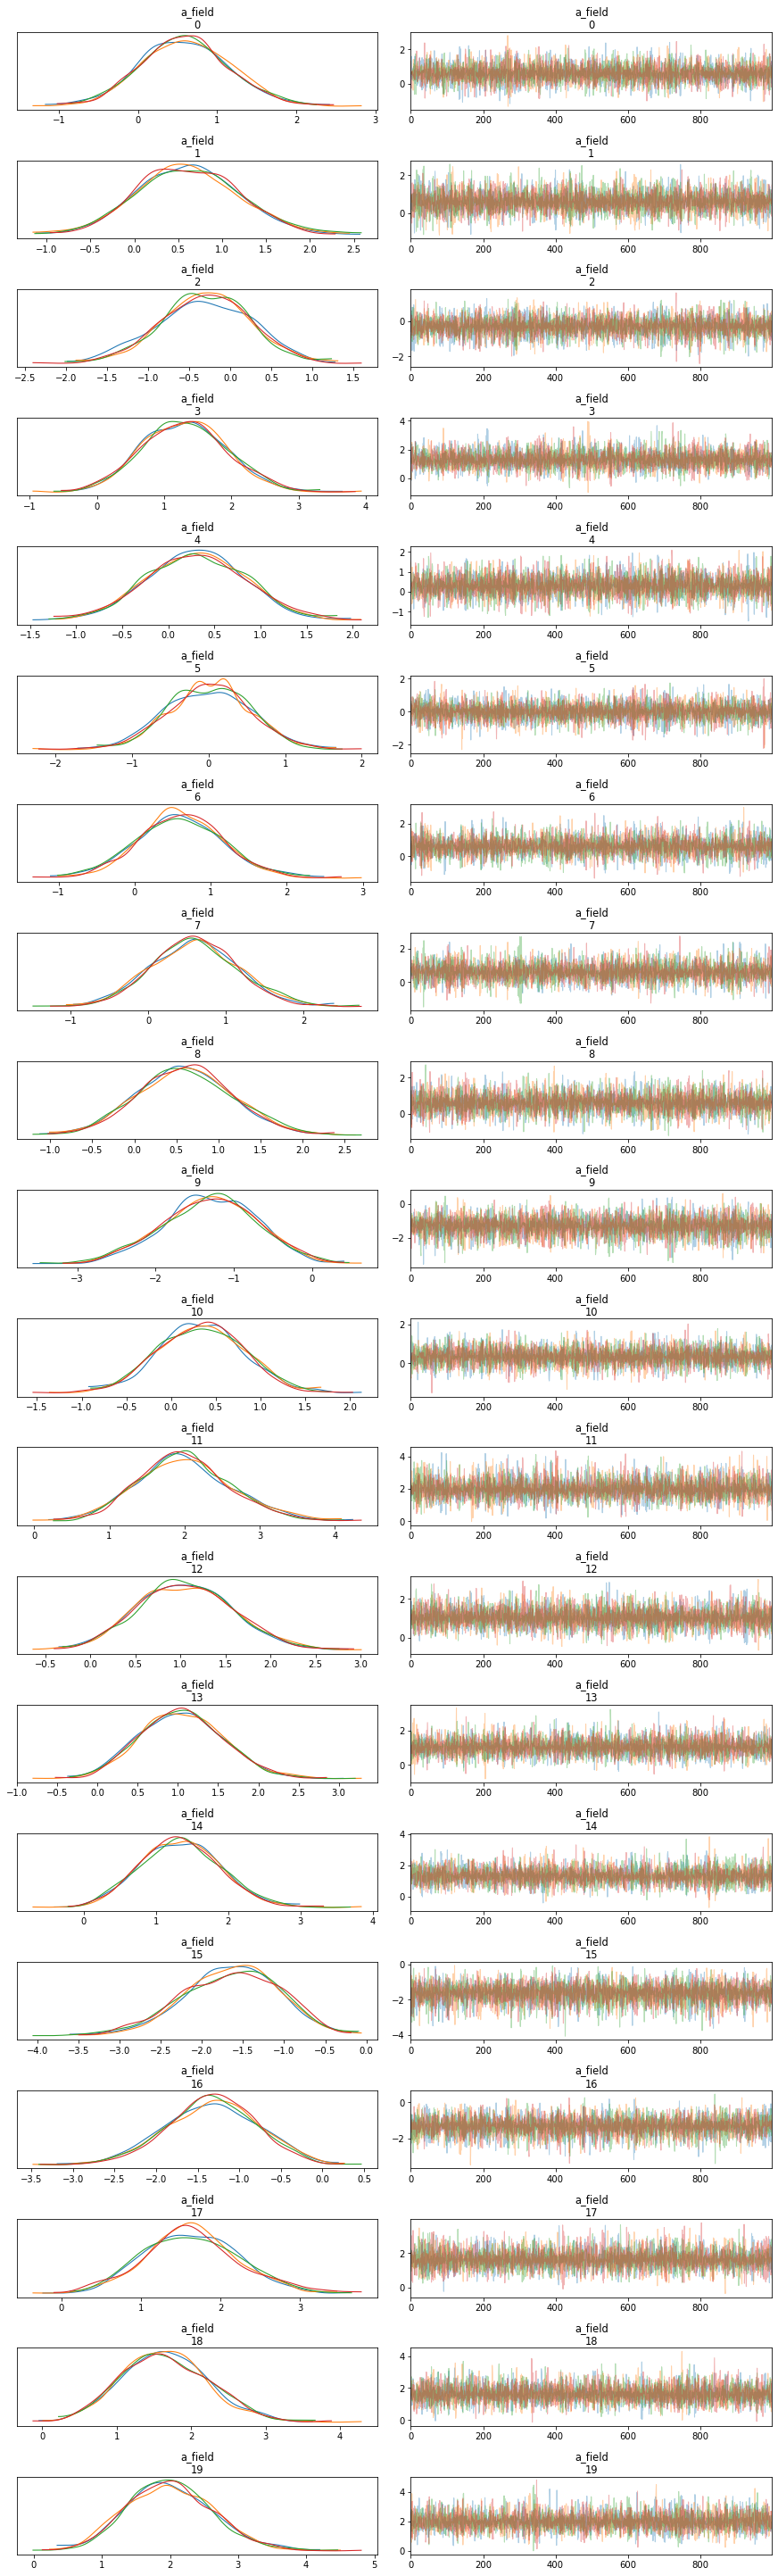

In [12]:
az.plot_trace(m_nopool_trace)

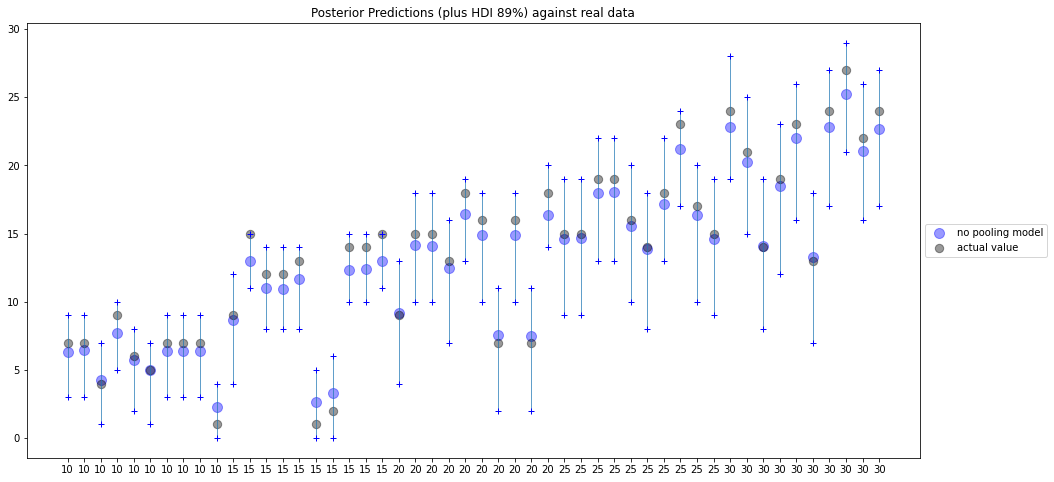

In [70]:
pool_plot(m_nopool_pred, 'no pooling model')

## Partial pooling model

In [71]:
with pm.Model() as m_parpool:
    a_bar = pm.Normal('a_bar', 0, 1)
    sigma = pm.Exponential('sigma', 2)
    
    a_field = pm.Normal('a_field', a_bar, sigma, shape=len(df.index.unique()))
    p = pm.math.invlogit(a_field[df.index])
    
    crops = pm.Binomial('crops', n=df.seeds, p=p, observed=df.crops)
    
    m_parpool_trace = pm.sample(tune=3000)
    m_parpool_pred = pm.sample_posterior_predictive(m_nopool_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_field, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 7 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (52), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_field\n0'}>,
        <AxesSubplot:title={'center':'a_field\n0'}>],
       [<AxesSubplot:title={'center':'a_field\n1'}>,
        <AxesSubplot:title={'center':'a_field\n1'}>],
       [<AxesSubplot:title={'center':'a_field\n2'}>,
        <AxesSubplot:title={'center':'a_field\n2'}>],
       [<AxesSubplot:title={'center':'a_field\n3'}>,
        <AxesSubplot:title={'center':'a_field\n3'}>],
       [<AxesSubplot:title={'center':'a_field\n4'}>,
        <AxesSubplot:title={'center':'a_field\n4'}>],
       [<AxesSubplot:title={'center':'a_field\n5'}>,
        <AxesSubplot:title={'center':'a_field\n5'}>],
       [<AxesSubplot:title={'center':'a_field\n6'}>,
        <AxesSubplot:title={'center':'a_field\n6'}>],
       [<AxesSubplot:title={'center':'a_field\n7'}>,
        <AxesSubplot:title={'center':'a_field\n7'}>],
       [<AxesSubplot:title={'center':'a_field\n

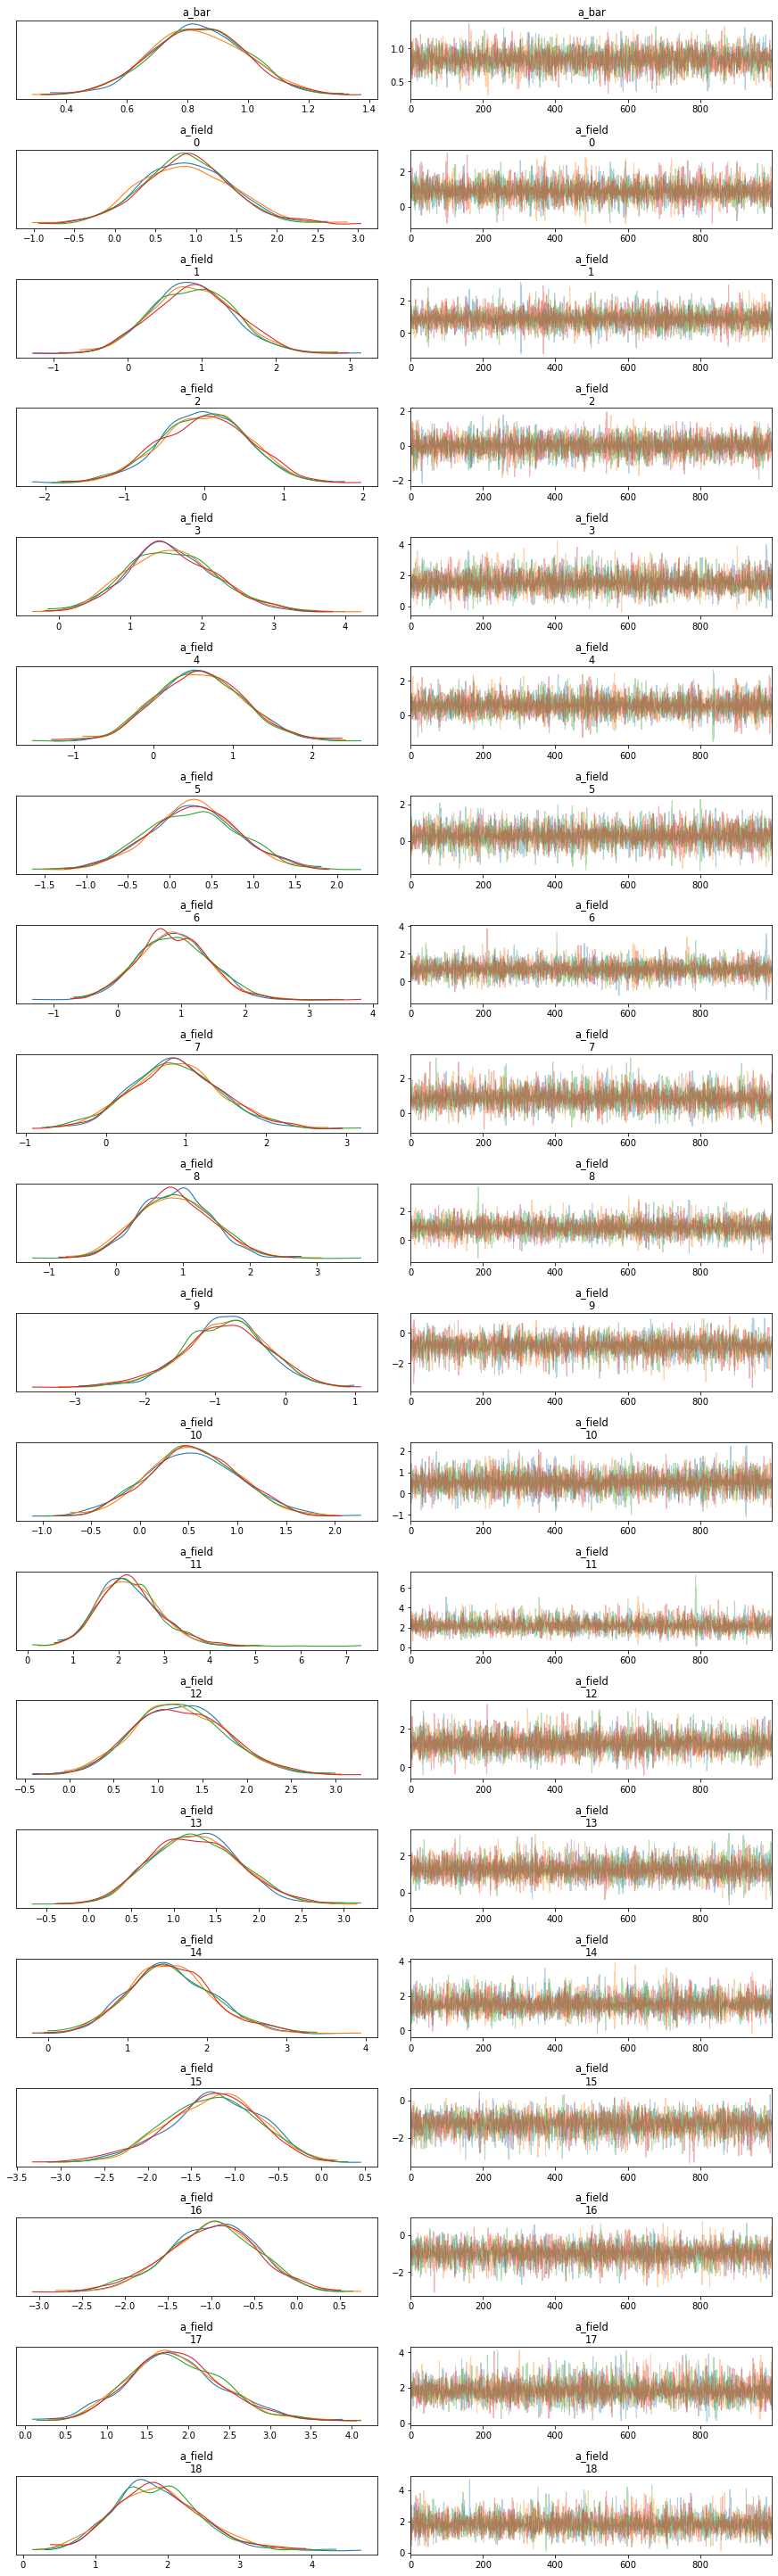

In [93]:
az.plot_trace(m_parpool_trace)

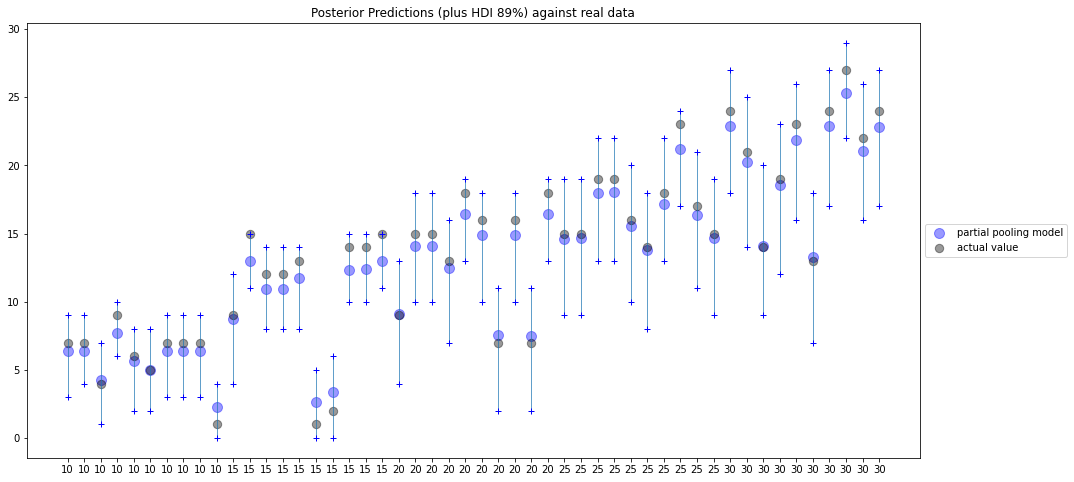

In [73]:
pool_plot(m_parpool_pred, 'partial pooling model')

---

In [23]:
seeds_grp = df.groupby(['seeds'])

for s in df.seeds.unique():
    np.abs(seeds_grp.get_group(s))
    print(s)
    

10
15
20
25
30


In [28]:
seeds_grp = df.groupby(['seeds'])

,seeds,crops,true_a,nopool_pred
field,,,,
0,10,7,0.831230,6.33925
1,10,7,0.560133,6.43000
2,10,4,0.542451,4.26900
3,10,9,1.329598,7.67900
4,10,6,0.081194,5.70900
5,10,5,0.456696,4.97325
6,10,7,1.231518,6.36250
7,10,7,1.756714,6.37525
8,10,7,0.828491,6.36075


In [35]:
np.abs(seeds_grp.get_group(10)['nopool_pred'] - seeds_grp.get_group(10)['crops']).mean()

0.634825

---
---

In [74]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Wed Mar 31 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

seaborn   : 0.11.0
numpy     : 1.19.1
arviz     : 0.10.0
pymc3     : 3.9.3
pandas    : 1.0.5
scipy     : 1.5.4
matplotlib: 3.3.2

Watermark: 2.1.0

